In [1]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakePerth
import numpy as np
from qiskit_experiments.library import StateTomography
from noisy_quantum_teleportation_benchmarking.QPU_optimized.teleportation_circuit_QPU_optimized import get_circuit, initialize_eigenvector_x_mas, to_z_basis
from noisy_quantum_teleportation_benchmarking.sampler import BaseInputSampler
from noisy_quantum_teleportation_benchmarking.channels import AmplitudeDampingChannel
from noisy_quantum_teleportation_benchmarking.distances import fidelity
from qiskit.compiler import transpile
from qiskit.quantum_info import DensityMatrix

In [2]:
adc = AmplitudeDampingChannel()
backend = AerSimulator()

In [3]:
from typing import Callable
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
from noisy_quantum_teleportation_benchmarking.channels import BaseChannel

type GateApplication = Callable[[QuantumCircuit, QuantumRegister], None]


def entangle(qc, q1, q2):
    qc.h(q1)
    qc.cx(q1, q2)


def bell_basis(qc, q1, q2):
    qc.cx(q1, q2)
    qc.h(q1)


def bob_correction(
    qc: QuantumCircuit,
    q1,
    q2,
    qbob,
):
    qc.cx(q1, qbob)
    qc.cz(q2, qbob)



def get_circuit(
    initializer: GateApplication,
) -> QuantumCircuit:
    input_reg = QuantumRegister(1, name="input")
    alice_reg = QuantumRegister(1, name="alice")
    bob_reg = QuantumRegister(1, name="bob")
    input_meas = ClassicalRegister(1, name="input_meas")
    alice_meas = ClassicalRegister(1, name="alice_meas")
    bob_meas = ClassicalRegister(1, name="bob_meas")

    qc = QuantumCircuit(input_reg, alice_reg, bob_reg, input_meas, alice_meas, bob_meas)

    initializer(qc, input_reg)

    entangle(qc, alice_reg[0], bob_reg[0])

    bell_basis(qc, input_reg[0], alice_reg[0])

    bob_correction(qc, alice_reg[0], input_reg[0], bob_reg[0])

    qc.measure(input_reg[0], input_meas)
    qc.measure(alice_reg[0], alice_meas)
    return qc

In [20]:
#qc = get_circuit(initialize_eigenvector_x_mas)

qc = QuantumCircuit(1)
qc.h(0)
qc.s(0)

# QST Experiment
qstexp1 = StateTomography(qc, measurement_indices=[0], target=DensityMatrix.from_label("r"))
qstdata1 = qstexp1.run(backend, seed_simulation=1000).block_for_results()

In [21]:
fid_result = qstdata1.analysis_results("state_fidelity")
print("State Fidelity = {:.5f}".format(fid_result.value))

State Fidelity = 0.99961


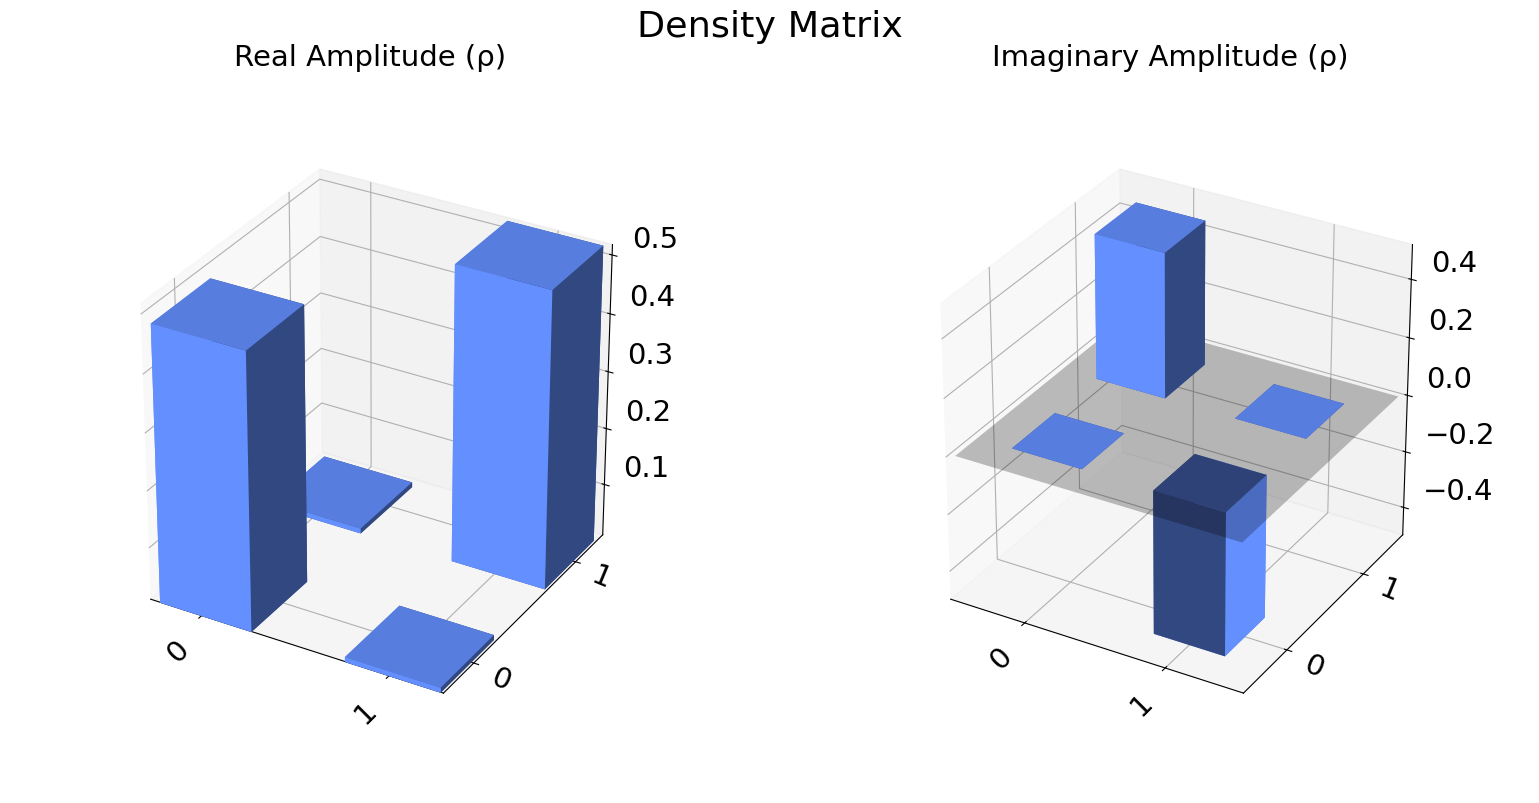

In [22]:
from qiskit.visualization import plot_state_city
plot_state_city(qstdata1.analysis_results("state").value, title='Density Matrix')